<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(S_inv @ param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        #print("alpha  ", a)
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    print("you are printing 1/alpha in function of coefs")
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    print("you are printing l1 norm in function of coefs")
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


end block


In [2]:
# imputation's block

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res ", res)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      #print(m_bool)
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      #print("matrices computed")
      #print(sigma_aa_inv)
      #print(sigma_ma)
      #print("wee", x_c[m_bool])
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      #print("mu cond ", mu_cond)
      x_imp[i, ~m_bool] = mu_cond
    #print("x_orig \n", x)
    #print("x_imp \n", x_imp)
    #print("diff\n", x - x_imp)
  return x_imp

#n = 3
#d = 4
#S = np.random.randint(low=1, high=10, size=(d, d))
#S = S.T @ S * 0 + np.eye(d)
#print(S)
#muu = np.array([10, 20, 30, 40])
#xx = np.random.randint(low=1, high=6, size=(n, d))
#mm = np.array([[0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1]])
#print(xx)
#print(mm)
#x, m = clear_dataset(xx, mm)
#print("cleaned ds \n", x)
#print("cleaned masks \n", mm)
#res = imputation_elliptic(muu, S, x, m)


In [3]:
# define observations

n = 300
d = 8
cov = np.random.randint(low=1, high=10, size=(d, d))
cov = cov.T @ cov + np.eye(d)
print(cov)
print(np.linalg.eigvalsh(cov))
#cov = np.eye(d)
X_orig = np.random.rand(n, d) @ cov
#X_orig = np.random.randint(low=1, high=4, size=(n, d)) * 1.0
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(d)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n, d))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
print("end block")

final shape  (300, 8)
end block


you are printing l1 norm in function of coefs


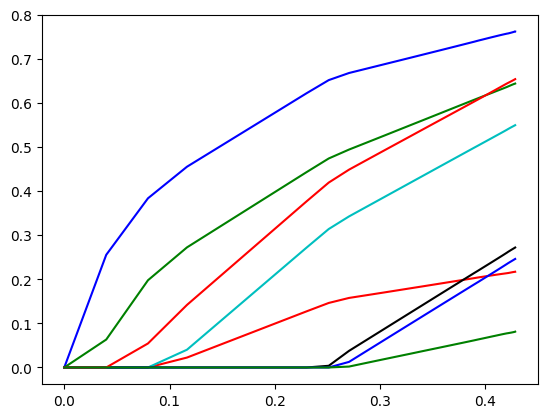

In [4]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

sd_orig  [0.28769216 0.28650756 0.27907994 0.29788859 0.28523718 0.28803977
 0.28817155 0.29781866]


 87%|████████▋ | 174/200 [00:23<00:14,  1.75it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:37<00:00,  5.28it/s]


you are printing l1 norm in function of coefs


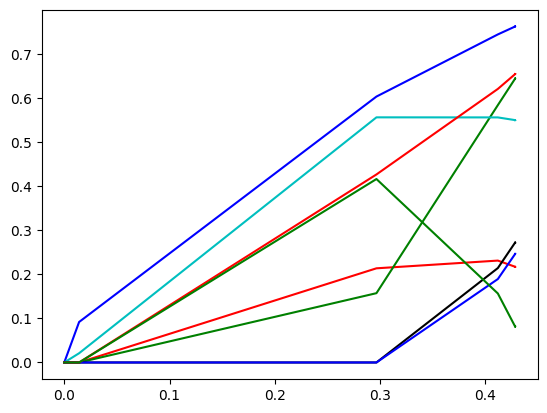

In [5]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
sd_orig = np.std(X_orig, axis=0)
print("sd_orig ", sd_orig)
S_inv_orig = np.diag(1 / sd_orig)
#S_inv_orig = np.eye(X_orig.shape[0])
linfadvtrain = AdversarialTraining(X_orig, y, S_inv_orig, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)
#plot_coefs(alphas_adv, coefs_advtrain_linf, ax)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(300, 8)
std_orig: 
 [0.28769216 0.28650756 0.27907994 0.29788859 0.28523718 0.28803977
 0.28817155 0.29781866]
std rf
  [0.26529142 0.26299522 0.25683889 0.26933211 0.24866025 0.25755571
 0.26496274 0.26932546]


 86%|████████▌ | 171/200 [00:19<00:21,  1.32it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:41<00:00,  4.79it/s]

you are printing l1 norm in function of coefs


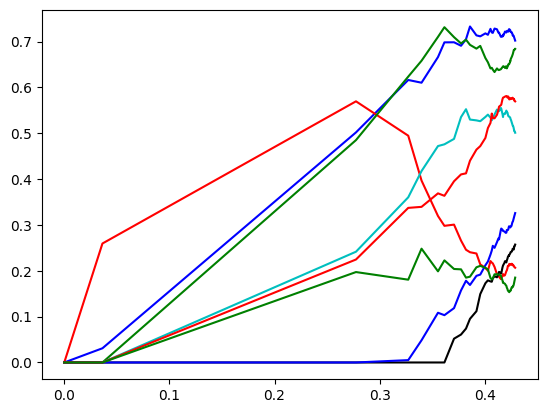

In [6]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


std_orig: 
 [0.28769216 0.28650756 0.27907994 0.29788859 0.28523718 0.28803977
 0.28817155 0.29781866]
std  br
  [0.25276416 0.24934713 0.24588471 0.25544395 0.23955434 0.24724175
 0.2546567  0.25773008]


 28%|██▊       | 56/200 [00:09<00:49,  2.89it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [01:17<00:00,  2.57it/s]

you are printing l1 norm in function of coefs


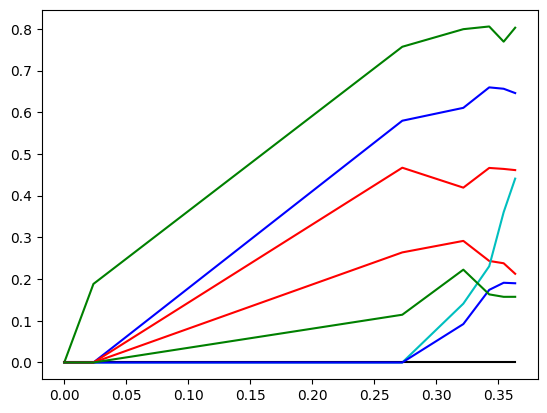

In [7]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

[0.25132052 0.24879939 0.24549583 0.25336451 0.23948035 0.2470564
 0.25465663 0.2573833 ]


 86%|████████▌ | 172/200 [00:11<00:09,  3.06it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:27<00:00,  7.23it/s]

you are printing l1 norm in function of coefs


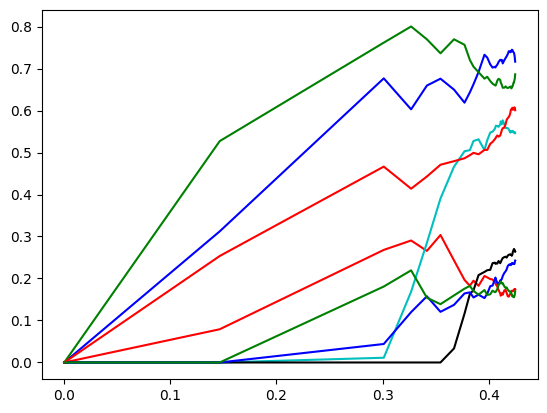

In [8]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


means  [0.50168072 0.51855591 0.52622092 0.47997039 0.4942381  0.50877832
 0.49976809 0.4964857 ]
delta  0.24666666666666667
nbr obs 300
eig cov  [0.02740948 0.02804817 0.02933831 0.02987801 0.03000929 0.03021199
 0.03063994 0.04764843]
300 8
sd ellp [0.25192262 0.24956098 0.24630801 0.25397269 0.24014941 0.24775784
 0.25512865 0.25786712]


100%|██████████| 200/200 [00:34<00:00,  5.87it/s]

you are printing l1 norm in function of coefs


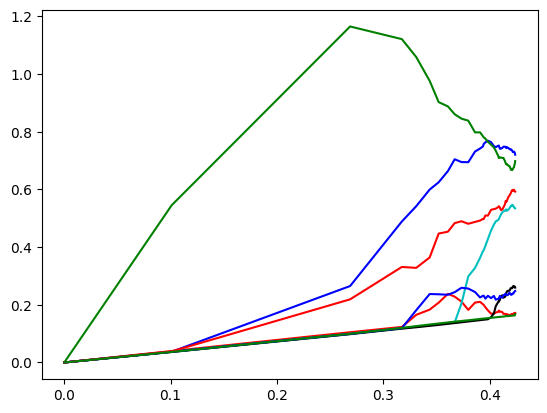

In [9]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
#print("diag ", np.diag(np.diag(S)))
S_ellp = (1/d - 1/(d**2)) * np.diag(np.diag(S_ellp)) + 1/(d**2) * S_ellp
#print("matrix \n", S_ellp)
print("eig cov ", np.linalg.eigvalsh(S_ellp))
#print("X_nan\n", X_nan)
#print(masks)
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#print(X_ellp)
S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
#S_inv_ellp = S_ellp
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)
#S_inv_ellp = np.diag(1 / sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
#plot_coefs(alphas_adv, coefs_advtrain_linf_ellp, ax)


In [ ]:
# mi bayesian ridge

number_multiple_imputed_datasets = 5
X_mi = np.vstack(multiple_imputation(number_multiple_imputed_datasets, X_nan))
sd_mi = np.std(X_mi, axis=0)
print("std_orig: \n", np.std(X_orig, axis=0))
print("sd_mi\n ", sd_mi)
S_inv_mi = np.diag(1 / sd_mi)
yy = np.concatenate([y] * number_multiple_imputed_datasets)

fig, ax = plt.subplots(num='advtrain_linf_mi')
linfadvtrain_mi = AdversarialTraining(X_mi, yy, S_inv_mi, p=np.inf)
estimator_mi = lambda X, y, a:  linfadvtrain_mi(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mi  = get_path(X_mi, yy, estimator_mi, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mi, ax)





std_orig: 
 [0.28769216 0.28650756 0.27907994 0.29788859 0.28523718 0.28803977
 0.28817155 0.29781866]
sd_mi
  [0.28908841 0.29382114 0.28590345 0.29022348 0.27951934 0.28435127
 0.2861     0.29840323]


 66%|██████▌   | 131/200 [00:33<01:24,  1.22s/it]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 74%|███████▍  | 148/200 [01:19<03:38,  4.21s/it]

In [ ]:
Observations:

-) If the data are np.random.randn(), all the graphs looks similar